In [53]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
from torchtext import data
from sklearn.metrics import f1_score
import pandas as pd 
import re
import random
import spacy
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt

In [54]:
# Loading the data from CSV file to a Pandas Data Frame 
raw_mail_data = pd.read_csv('./data/mail_data.csv')

In [55]:
print(raw_mail_data.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [56]:
# Replaces the null values in the data with an empty string
mail_data = raw_mail_data.where((pd.notnull(raw_mail_data)),'')

In [35]:
mail_data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [36]:
#Checking the number of rows and columns
mail_data.shape

(5572, 2)

# Lable encoding

In [37]:
# change the spam and non spam lables of the emails with 1 and zero
mail_data.loc[mail_data['Category'] == 'spam','Category',] = 0
mail_data.loc[mail_data['Category'] == 'ham','Category',] = 1

In [38]:
# Seperating the data into features and targets
X, Y = mail_data['Message'], mail_data['Category']

In [39]:
nlp = spacy.load('en_core_web_md')
X_vector = []
pbar = tqdm.trange(X.shape[0])
for t in pbar:
    doc = nlp(X[t])
    doc_tensor = []
    for i in range(len(doc)):
        word_tensor = torch.tensor(doc[i].vector)
        doc_tensor.append(word_tensor.reshape(1,len(word_tensor)))
    X_vector.append(doc_tensor)

100%|█████████████████████████████████████████████████████████████████████████████| 5572/5572 [00:29<00:00, 190.70it/s]


In [49]:
X_vector = np.array(X_vector)
X_train, X_test, Y_train, Y_test = train_test_split(X_vector, Y, test_size=0.2, random_state= 3)

Y_train = Y_train.astype("int64")
Y_test = Y_test.astype("int64")

Y_train = torch.from_numpy(Y_train.values)
Y_test = torch.from_numpy(Y_test.values)

Y_test = Y_test.view(Y_test.shape[0],1)
Y_train = Y_train.view(Y_train.shape[0],1)

print(X_train.shape, X_test.shape)

(4457,) (1115,)


In [50]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_dims,  hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h_ = nn.Linear(input_size + hidden_size, hidden_dims)
        self.h_2h = nn.Linear(hidden_dims, hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_dims)
        self.h2o = nn.Linear(hidden_dims, output_size)
        self.softmax = nn.LogSoftmax(dim= 1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden1  = self.i2h_(combined)
        hidden = self.h_2h(hidden1)
        hidden2 = self.i2h(combined)
        output = self.softmax(self.h2o(hidden2))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [51]:
# we will keep feeding the RNN one row at a time 
input_size = 300
n_hidden = 300
hidden_dims = 200

n_categories = 2
num_epochs = 2
learning_rate = 0.0005
all_losses = []

rnn = RNN(input_size, hidden_dims, n_hidden, n_categories)

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

n_iters = 100000
current_loss = 0

plot_steps, print_steps = 1000, 1000

def category_from_output(output):
    category_index = torch.argmax(output).item()
    return category_index

for i in range(n_iters):
    hidden = rnn.init_hidden()
    index = random.randint(0, len(X_train) - 1)
    doc = X_train[index]
    for word_tensor in doc:
        output, hidden = rnn(word_tensor, hidden)
    loss = criterion(output, Y_train[index])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    current_loss += loss.item()
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss/ plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "Correct" if guess == Y_train[index].item() else f"Wrong ({Y_train[index].item()})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} / {guess} {correct}")

1000 1.0 1.5444 / 1 Wrong (0)
2000 2.0 0.1666 / 1 Correct
3000 3.0 0.0227 / 1 Correct
4000 4.0 0.0017 / 1 Correct
5000 5.0 0.0017 / 1 Correct
6000 6.0 0.0021 / 1 Correct
7000 7.000000000000001 0.0456 / 1 Correct
8000 8.0 0.5530 / 1 Correct
9000 9.0 0.0004 / 1 Correct
10000 10.0 0.0135 / 1 Correct
11000 11.0 0.3304 / 0 Correct
12000 12.0 0.0001 / 1 Correct
13000 13.0 0.0002 / 1 Correct
14000 14.000000000000002 0.0000 / 1 Correct
15000 15.0 0.0000 / 1 Correct
16000 16.0 0.0002 / 1 Correct
17000 17.0 0.0021 / 1 Correct
18000 18.0 0.0630 / 1 Correct
19000 19.0 0.0000 / 1 Correct
20000 20.0 0.0001 / 1 Correct
21000 21.0 0.0001 / 1 Correct
22000 22.0 0.0000 / 1 Correct
23000 23.0 0.0057 / 0 Correct
24000 24.0 0.0008 / 1 Correct
25000 25.0 0.0320 / 1 Correct
26000 26.0 0.1654 / 1 Correct
27000 27.0 0.0462 / 1 Correct
28000 28.000000000000004 0.0000 / 1 Correct
29000 28.999999999999996 0.0022 / 1 Correct
30000 30.0 0.0017 / 1 Correct
31000 31.0 0.0000 / 1 Correct
32000 32.0 0.0292 / 1 Correct


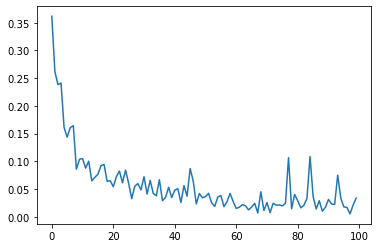

In [57]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [58]:
correct = 0
y_pred = []
y_true = []
for i , doc  in enumerate(X_test):
    hidden = rnn.init_hidden()
    for word_tensor in doc:
        output, hidden = rnn(word_tensor, hidden)
    guess  = category_from_output(output)
    y_pred.append(guess)
    y_true.append(Y_test[i].item())
    if guess == Y_test[i].item():
        correct += 1
print(correct/ Y_test.shape[0])

0.9641255605381166


# Splitting Data into Test and Train

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 3)

In [43]:
print(X_train.shape, X_test.shape)

(4457,) (1115,)


# Feature Extraction

In [47]:
# Transfrom The text data into feature vector used as input to the ml model
# Goes over all the words in the data set and based on its frequence will give those words a value
# Min_df = 1 states that if the sore allocated to a word is less than one then we ignore it
feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase='True')
# Below we fit the vectorizer to the training data 
X_train_features = feature_extraction.fit_transform(X_train)
# not need to fit this time only transform based on the previous fit
X_test_features = feature_extraction.transform(X_test)

# convert all values of Y_train and Y_test to integers 
Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")

In [50]:
print(X_train_features.shape)

(4457, 7431)


# Training

In [51]:
model = LogisticRegression()
# training the logistic regression model with the training data 
model.fit(X_train_features, Y_train)

# Evaluation of Model

In [60]:
prediction_on_train_data = model.predict(X_train_features)
accuracy_on_train_data = accuracy_score(Y_train, prediction_on_train_data)

In [61]:
print(accuracy_on_train_data)

0.9670181736594121


In [62]:
prediction_on_test_data = model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test, prediction_on_test_data)

In [63]:
print(accuracy_on_test_data)

0.9659192825112107


# Building a predictive system

In [66]:
input_mail = ["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]
input_feature_mail = feature_extraction.transform(input_mail)
print(model.predict(input_feature_mail))

[0]
